# Modeling

In [14]:
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.layers import InputLayer
from keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping

import pickle
import random

Reading train and test data from the disk using pickle

In [3]:
for dt in ['X_train', 'X_test', 'y_train', 'y_test']:
    with open(f'{dt}.pkl','rb') as f:
        vars()[dt] = pickle.load(f)

Now building a neural network with several layers

In [4]:
# create sequential model
model = Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(20,20, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(126, activation='relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

I use adam optimizer. I found the optimal learning rate to be 0.00001 by iterating over a sevaral values. 

In [5]:
optimizer = keras.optimizers.Adam(lr=0.00001) # optimal lr is found by manual iteration and test

# compile model. Use accuracy as metrics for easy interpretation
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#### Data Augmentation
I tried to train the model w/o data augmentation and found that it fits better with the following augmentations.

In [6]:
# performing data augmentation by training image generator
datagen_test = ImageDataGenerator(#brightness_range=(0.2, 1.2), 
                                  rotation_range = 10,
                                  #fill_mode = "nearest",
                                  horizontal_flip = True,
                                  vertical_flip = True)

datagen_train = ImageDataGenerator(#brightness_range=(0.2, 1.2),
                                   rotation_range = 10,
                                   #fill_mode = "nearest",
                                   horizontal_flip = True,
                                   vertical_flip = True)
# Apply the augmentations
datagen_train.fit(X_train)
validation_generator = datagen_test.flow(X_test, y_test, batch_size = 32)

#### Training the model

In [7]:
# creating early stopping object 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
# train the model
history = model.fit(datagen_train.flow(X_train, y_train, batch_size = 32),
                               steps_per_epoch = len(X_train) // 32,
                               validation_data = validation_generator,
                               epochs = 200, callbacks=[es], workers=4)

Epoch 1/200
800/800 [==============================] - 13s 16ms/step - loss: 0.6227 - accuracy: 0.7492 - val_loss: 0.5739 - val_accuracy: 0.7500
Epoch 2/200
800/800 [==============================] - 17s 21ms/step - loss: 0.5558 - accuracy: 0.7455 - val_loss: 0.4498 - val_accuracy: 0.7511
Epoch 3/200
800/800 [==============================] - 17s 22ms/step - loss: 0.4120 - accuracy: 0.7881 - val_loss: 0.3467 - val_accuracy: 0.8420
Epoch 4/200
800/800 [==============================] - 16s 21ms/step - loss: 0.3303 - accuracy: 0.8597 - val_loss: 0.3106 - val_accuracy: 0.8755
Epoch 5/200
800/800 [==============================] - 17s 21ms/step - loss: 0.2983 - accuracy: 0.8782 - val_loss: 0.2885 - val_accuracy: 0.8797
Epoch 6/200
800/800 [==============================] - 16s 20ms/step - loss: 0.2734 - accuracy: 0.8877 - val_loss: 0.2686 - val_accuracy: 0.8906
Epoch 7/200
800/800 [==============================] - 17s 21ms/step - loss: 0.2577 - accuracy: 0.8952 - val_loss: 0.2515 - val_ac

In [8]:
model.evaluate(X_test, y_test)

200/200 [==============================] - 1s 3ms/step - loss: 0.1020 - accuracy: 0.9627


[0.10202488303184509, 0.9626562595367432]

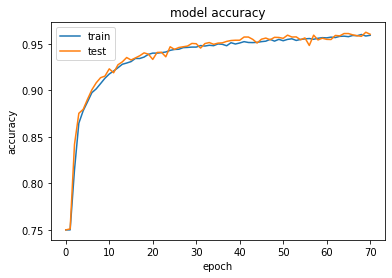

In [9]:
# accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

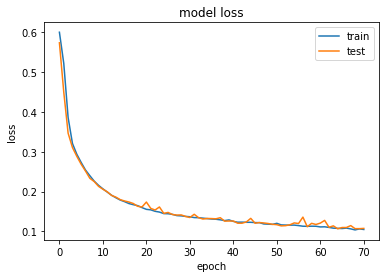

In [10]:
# loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

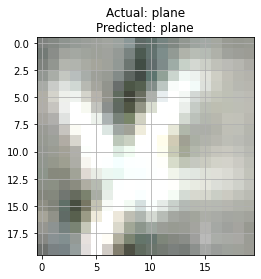

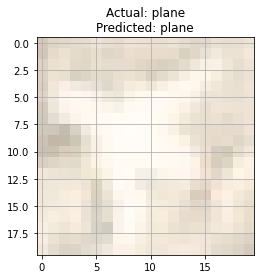

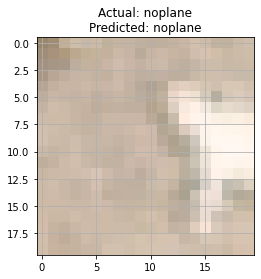

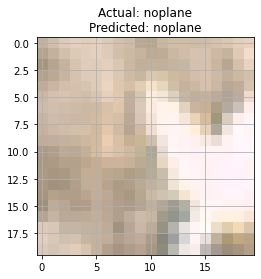

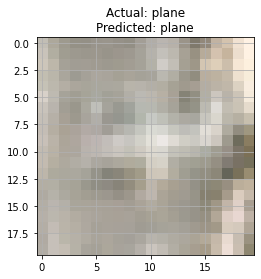

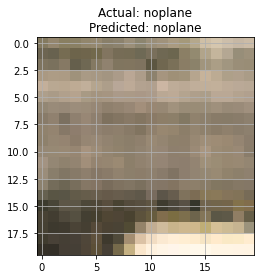

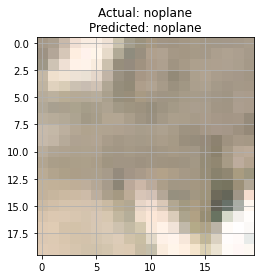

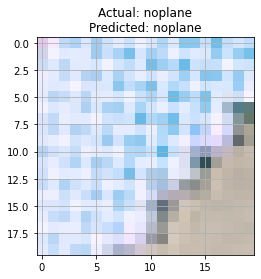

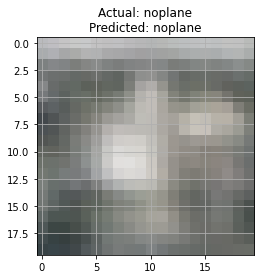

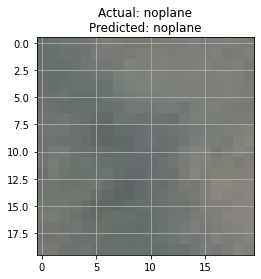

In [15]:
# check the model
names = ['noplane', 'plane']
names_label = {name:i for i, name in enumerate (names)}

pred_y= model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)

test_y = np.argmax(y_test, axis=1)

rnd_smp = random.sample(range(0,400),10)
_labels_ = {i:name for (name,i) in names_label.items()}

for i, smp in enumerate(rnd_smp):
    
    plt.imshow(X_test[smp])
    
    plt.title("Actual: {}\nPredicted: {}".format(_labels_[test_y[smp]], _labels_[pred_y[smp]]))
    plt.grid(None)
    plt.show()
    pass

In [16]:
y_pred = model.predict(X_test)
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0
y_pred=np.asarray(y_pred, dtype=bool)
target_names = ['No Plane', 'Plane']
print(classification_report(y_test, y_pred, target_names=target_names))
print('Accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    No Plane       0.98      0.97      0.97      4800
       Plane       0.90      0.95      0.93      1600

   micro avg       0.96      0.96      0.96      6400
   macro avg       0.94      0.96      0.95      6400
weighted avg       0.96      0.96      0.96      6400
 samples avg       0.96      0.96      0.96      6400

Accuracy: 0.96265625
